# Setting

# **Data Analysis**

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"young917","key":"38554d8ee11a16273014fb43b7fdc0a1"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3210           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      23719           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5442            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        392           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1722            True  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       7207   

In [0]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 49.2MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 62.7MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.7MB/s]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
import spacy

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [0]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [0]:
train.head(10)

,50
category_name,category_type
Anorak,1
Blazer,1
Blouse,1
Bomber,1
Button-Down,1
Cardigan,1
Flannel,1
Halter,1
Henley,1


In [0]:
print(train.shape)

(51, 1)


In [0]:
print("[sample data] train\n")
train.sample(n=10)

[sample data] train



,id,keyword,location,text,target
1445,2083,casualty,NaN,AM Best Special Report: How Metrics Correlate to AM Best's Property/Casualty ... - MarketWatch http://t.co/mVrsYu2PPK,0
4692,6669,landslide,Scotland,FreeBesieged: .MartinMJ22 YouGov Which '#Tory landslide' ... you can't POSSIBLY mean the wafer-thin majority of #GÛ_ http://t.co/2q3fuEReY5,1
1639,2367,collapsed,NaN,1 hour parade like 50 people collapsed. #OneHeartOneMindOneCSS,1
6011,8584,screams,5-Feb,When you go to a concert and someone screams in your ear... Does it look like I wanna loose my hearing anytime soon???,1
1244,1792,buildings%20on%20fire,"Fort Walton Beach, Fl",They are evacuating buildings in that area of State Road 20. We still don't have confirmation of what is on fire.,1
4436,6312,hostage,Global,The horrific story of being a hostage - The horrific story of being a hostage It's 1974 and on a British... http://t.co/XcQ48OuRvL,1
1132,1632,bombing,Shipwreck Cove,It's been 70 years (and one hour) since the bombing of Hiroshima. Let's take this time to remember.,1
3787,5379,fire%20truck,NaN,@KapoKekito on northgate by the taco truck that's fire.,1
937,1354,blown%20up,Nowhere Islands/Smash Manor,@TheBoyOfMasks 'Thanks again for letting me stay here since the manor was blown up..... Anyways how are you doing buddy?',0
5921,8453,screamed,sneaking glances at Thancred,@mogacola @zamtriossu i screamed after hitting tweet,0


In [0]:
print("[Null Data] train\n")
train.isnull().sum(),
print("[Null Data] test\n")
test.isnull().sum()

[Null Data] train

[Null Data] test



id          0   
keyword     26  
location    1105
text        0   
dtype: int64

In [0]:
dup_tweets = train[train.duplicated(['text'], keep = False)].sort_values('text')
print('[Total duplicates]',dup_tweets.shape[0],'\n[Total unique]',dup_tweets['text'].nunique(dropna = False))
dup_tweets.head(10)

[Total duplicates] 179 
[Total unique] 69


,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6378,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
2828,4064,displaced,NaN,#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,1


### Observation

#### 1. shape는 (7613, 5) (3263, 4) (10876, 4)
> target 제외하고 twitter 하나당 id, keyword, location, text를 가지고 있다.

#### 2. text:
> http나 @ 등도 포함하고 있기에 정제하는 작업이 필요할 것 같다.

#### 3. keyword:
> random하게 살펴본 데이터로는 알맞은 데이터가 들어가 있는 것으로 보인다. 또한 비어있는 경우도 61가지 밖에 없기 때문에 이를 training에 이용하면 좋겠다는 생각이 든다.

#### 4. location:
> Taylor Swift, Does it really matter! 등 알맞지 않은 데이터도 존재하기 때문에 사용하지 않거나 정제하는 작업이 필요할 것으로 보인다.

####5. target:
> 생각했던 것과 다르게, 같은 text이지만 다른 target을 갖은 데이터도 train에 포함되어있음을 확인할 수 있었다.

### Class Distribution
<- 문제의 난이도 생각해볼 수 있다.

Text(0.5, 0, 'target')

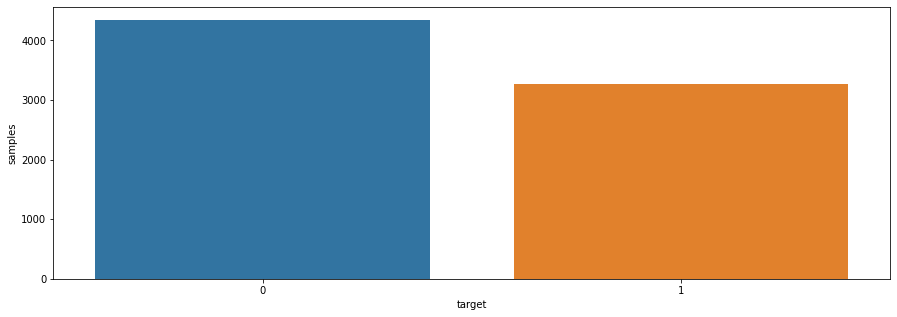

In [0]:
x = train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.gca().set_xlabel('target')

#### Observation:

문제의 난이도를 생각해볼 수 있는데,

target이 0인 경우와 1인 경우가 비슷한 수로 분포하는 것으로 보아 둘에 대한 정보를 비슷하게 얻어낼 수 있을 것 같다.

## keyword와 location 분석

In [0]:
train.fillna('', inplace=True)

In [0]:
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [0]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop=set(stopwords.words('english'))

punctuation = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import re

df = train

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

from nltk.stem import WordNetLemmatizer

# lemmatization keyword
def lemmentize(keyword):
    lmtzr = WordNetLemmatizer()
    keyword = lmtzr.lemmatize(keyword)
    keyword = lmtzr.lemmatize(keyword, 'v')
    return keyword

df['keyword'] = df['keyword'].apply(lambda x : lemmentize(x))

In [0]:
data = df
a = data.groupby(['keyword', 'target']).size().unstack(fill_value=0)
a['fraction'] = a[1] / (a[0] + a[1])
a = a.sort_values(by=[1], axis=0, ascending=False)
a[:30]

target,0,1,fraction
keyword,,,
flood,43,66,0.605505
bomb,40,61,0.603960
evacuate,19,57,0.750000
attack,25,46,0.647887
derail,30,43,0.589041
casualty,26,43,0.623188
,19,42,0.688525
hostage,26,42,0.617647
outbreak,1,39,0.975000


In [0]:
aa = a.sort_values(by ='fraction' )

In [0]:
aa[:30]

target,0,1,fraction
keyword,,,
aftershock,34,0,0.000000
body%20bags,40,1,0.024390
ruin,36,1,0.027027
body%20bag,32,1,0.030303
traumatise,33,2,0.057143
blew%20up,31,2,0.060606
blight,30,2,0.062500
panic,65,5,0.071429
blaze,66,6,0.083333


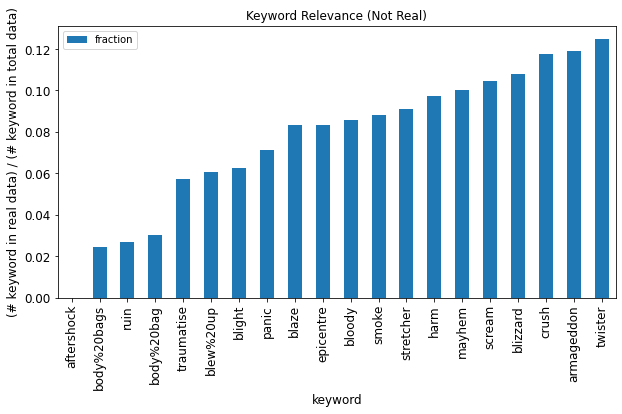

In [0]:
ax = aa['fraction'][:20].plot(kind='bar', title ="Keyword Relevance (Not Real)", figsize=(10, 5), legend=True, fontsize=12)
ax.set_xlabel("keyword", fontsize=12)
ax.set_ylabel("(# keyword in real data) / (# keyword in total data)", fontsize=12)
plt.show()

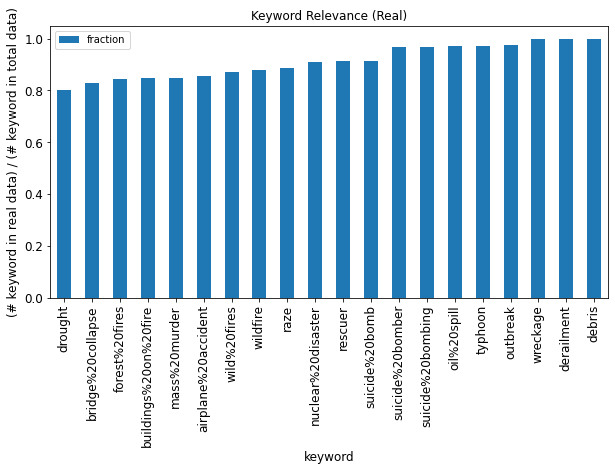

In [0]:
ax = aa['fraction'][-20:].plot(kind='bar', title ="Keyword Relevance (Real)", figsize=(10, 5), legend=True, fontsize=12)
ax.set_xlabel("keyword", fontsize=12)
ax.set_ylabel("(# keyword in real data) / (# keyword in total data)", fontsize=12)
plt.show()

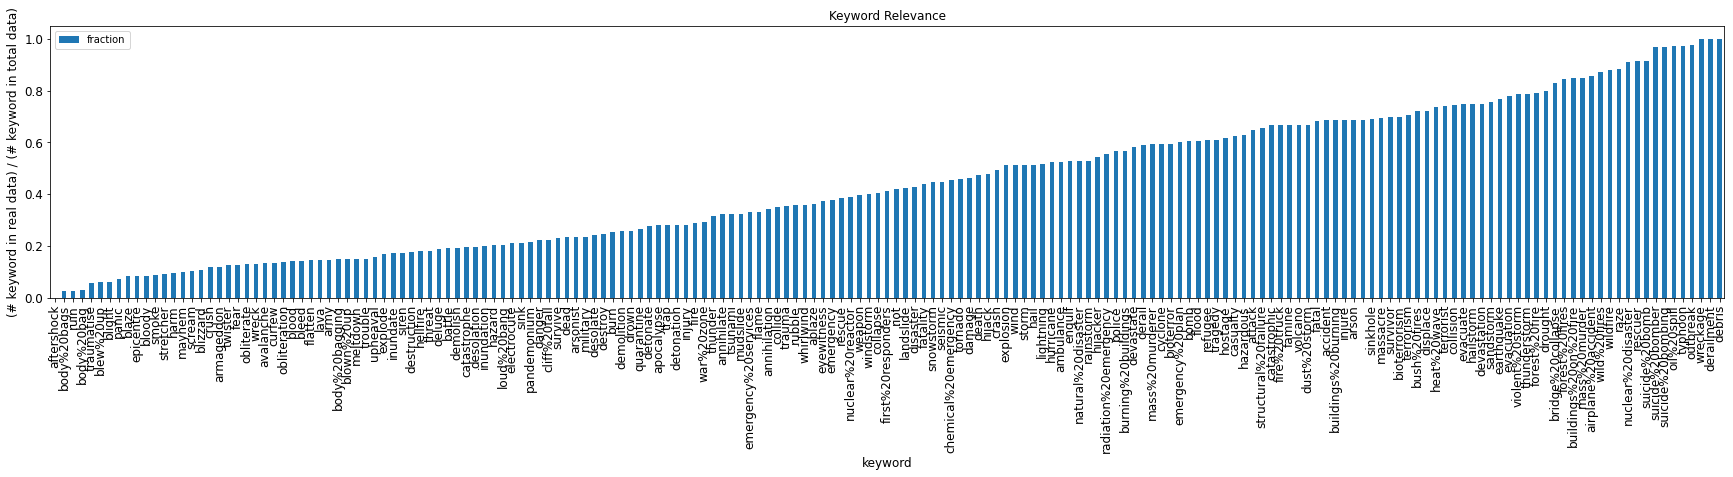

In [0]:
ax = aa['fraction'].plot(kind='bar', title ="Keyword Relevance", figsize=(30, 5), legend=True, fontsize=12)
ax.set_xlabel("keyword", fontsize=12)
ax.set_ylabel("(# keyword in real data) / (# keyword in total data)", fontsize=12)
plt.show()

In [0]:
train = data

### Observation

##### target = 1인 데이터 중 가장 많이 나타난 keyword 순으로 (target = 1에 나타난 횟수 / target = 0에 나타난 횟수) 를 살펴보았을 때, 모두 0.6 ~ 1.0 사이의 값을 보이는 것을 알 수 있었다. 따라서 keyword가 유의미한 데이터가 될 수 있음을 파악할 수 있었다.

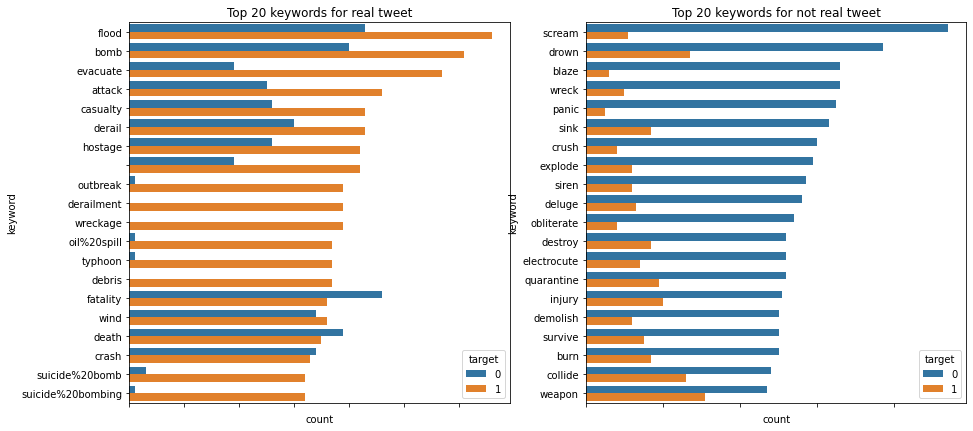

In [0]:
# top 20 keyword frequency in real and not real disaster tweets
train['keyword'] = train['keyword'].fillna('NA')
real = train[train['target'] == 1]
noreal = train[train['target'] == 0]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
sns.countplot(y='keyword',hue = 'target', data = train, order = real['keyword'].value_counts()[:20].index, ax= ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Top 20 keywords for real tweet')
sns.countplot(y='keyword',hue = 'target', data = train, order = noreal['keyword'].value_counts()[:20].index, ax= ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Top 20 keywords for not real tweet')
print()

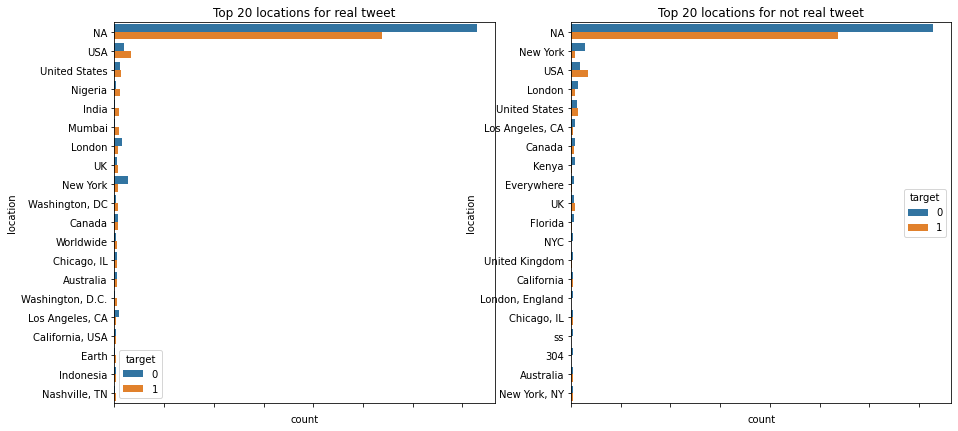

In [0]:
# top 20 keyword frequency in real and not real disaster tweets
train['location'] = train['location'].fillna('NA')
real = train[train['target'] == 1]
noreal = train[train['target'] == 0]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
sns.countplot(y='location',hue = 'target', data = train, order = real['location'].value_counts()[:20].index, ax= ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Top 20 locations for real tweet')
sns.countplot(y='location',hue = 'target', data = train, order = noreal['location'].value_counts()[:20].index, ax= ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Top 20 locations for not real tweet')
print()

# **Fixing Data**

## Stop Word

- Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.

In [0]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

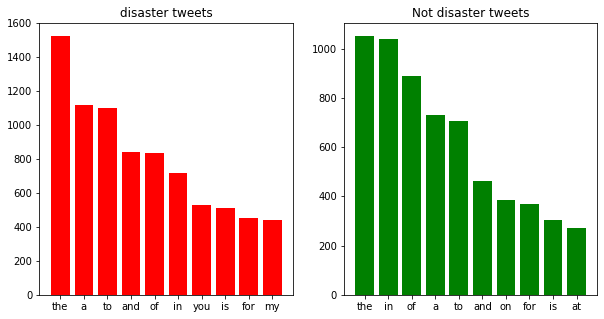

In [0]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict

stop=set(stopwords.words('english'))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
plt.title("Stop Words")

corpus=create_corpus(0)
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
train_stopwords=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*train_stopwords)
ax1.bar(x, y,color='red')
ax1.set_title('disaster tweets')

corpus=create_corpus(1)
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
train_stopwords=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*train_stopwords)
ax2.bar(x, y,color='green')
ax2.set_title('Not disaster tweets')
plt.show()

## Punctuation

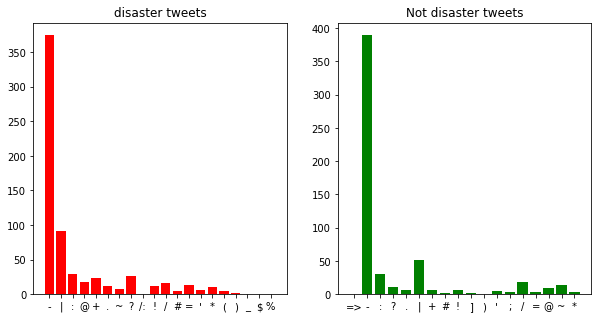

In [0]:
import string
punctuation = string.punctuation

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

corpus=create_corpus(0)
dic=defaultdict(int)
for word in corpus:
    if word in punctuation:
        dic[word]+=1

x,y=zip(*dic.items())
ax1.bar(x, y,color='red')
ax1.set_title('disaster tweets')

corpus=create_corpus(1)
dic=defaultdict(int)
for word in corpus:
    if word in punctuation:
        dic[word]+=1
x,y=zip(*dic.items())
ax2.bar(x, y,color='green')
ax2.set_title('Not disaster tweets')
plt.show()

##### Observation:

해석하는 데 필요하지 않은 구두점이 많이 존재하고 있음을 볼 수 있다.

##### Observation

stop words와 punctuation 결과를 보아 해석하는 데 필요하지 않을 단어를 지우는 작업이 필요할 것으로 보인다.

## Data Cleaning

In [0]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [0]:
import re

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

# **Additional Analysis**

## Train data: distribution of length

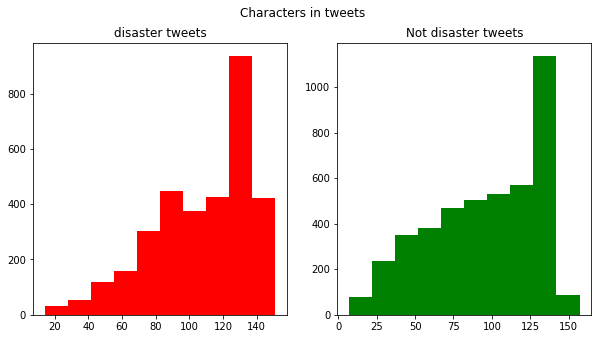

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

##### Observation:

재난 상황을 알리는 트위터와 그렇지 않은 트위터가 가진 길이 분포를 보았을 때, 재난 상황과 관련되지 않은 트위터가 길이가 주로 좀 더 길다는 판단을 할 수 있었다. 
이러한 특징을 모델이 파악할 수 있도록 해야되겠다.

## Train data: distribution of number of words 

Text(0.5, 0.98, 'Average word length in each tweet')

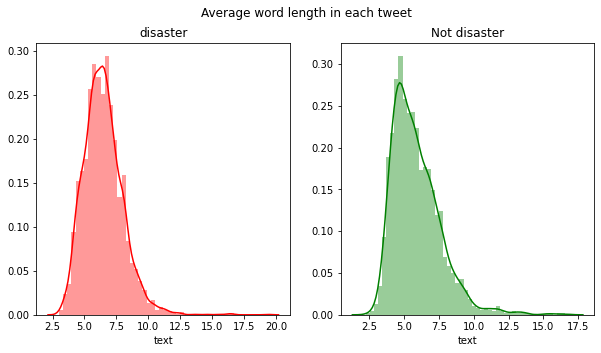

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

##### Observation:

실제 재난 상황을 알리는 트위터와 아닌 경우 모두 포함하고 있는 단어의 수 분포는 비슷한 것으로 보아 중요한 특징이 되지 않을 것 같다.